In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def gen_pc_data(N, M, R, percent_moonlight):
    
    # First generate W
    W = np.zeros((N,R))
    moonlight_genes = np.random.uniform(0,1,N)
    moonlight_genes = moonlight_genes<percent_moonlight
    
    # Pick the modules for each gene
    for gene_idx in range(N):
        if moonlight_genes[gene_idx]:
            num_mods = np.random.randint(2,R+1)
            gene_mods = np.random.randint(0,R,num_mods)
            W[gene_idx, gene_mods] = 1
        else: 
            gene_mod = np.random.randint(0,R)
            W[gene_idx, gene_mod] = 1
    # Pick the relative expression levels of each gene for each module
    for mod_idx in range(R):
        # Handel the case where a module has no genes (very unlikely for N >> R)
        if W[:,mod_idx].sum() == 0:
            W[np.random.randint(0,N),mod_idx] = 1
            
        else:
            col_arr = W[:,mod_idx]
            col_sum = int(col_arr.sum())
            dir_params = np.ones(col_sum)
            gene_expressions_arr = np.random.dirichlet(dir_params)
            idx_arr = np.argwhere(col_arr != 0)
            col_arr[idx_arr] = gene_expressions_arr[:,np.newaxis]
            W[:, mod_idx] = col_arr
            
    # Then generate H
    H = np.ones((R,M))
    H = np.apply_along_axis(np.random.dirichlet, 0, H)
    
    # Now generate V from W and H
    #TODO change the way we add counts, should be based on the number of samples (does it need to be different 
    # acrross samples as well?)
    V = 1e6*np.matmul(W, H)
    V = np.random.poisson(V)
            
    return W, H, V

In [3]:
# Generate simulated data where we are observing 100 genes in 60 samples with 5 gene batteries and ~5 percent
# of genes are moonlighting genes
W1_true, H1_true, V1 = gen_pc_data(20,10,3,0.05)
W2_true, H2_true, V2 = gen_pc_data(20,10,4,0.05)
W3_true, H3_true, V3 = gen_pc_data(20,10,5,0.05)

In [4]:
def iterate_NMF(V, R, N):
    
    iteration_num_list = []
    dims = V.shape
    C = V.sum(axis=0)
    C = C[np.newaxis,:]
    
    best_LL = -1
    best_W = -1
    best_H = -1
    
    for epoch in range(N):
        
        # Initiate random W and H
        epoch_W, epoch_H = np.ones((dims[0],R)), np.ones((R,dims[1]))
        epoch_W = np.apply_along_axis(np.random.dirichlet, 0, epoch_W)
        epoch_H = np.apply_along_axis(np.random.dirichlet, 0, epoch_H)
        epoch_LL = -1

        for iteration in range(100000):

            # Get matrices for W and H update
            Lamda = np.multiply(C,np.matmul(epoch_W,epoch_H))
            P = np.divide(V, Lamda)
            CH = np.multiply(C,epoch_H)

            # Broadcast into higher dimensions and perform element-wise multiplication for W update
            P_3d = P[:,np.newaxis,:]
            CH_3d = CH[np.newaxis,:,:]
            L_W = np.multiply(P_3d,CH_3d).sum(axis=2)

            # Get new W
            W_new = np.multiply(epoch_W,L_W)
            norm_term = W_new.sum(axis=0)[np.newaxis,:]
            W_new = np.divide(W_new,norm_term)

            # Broadcast into higher dimensions and perform element-wise multiplication for H update
            W_3d = epoch_W[:,:,np.newaxis]
            L_H = np.multiply(P_3d,W_3d).sum(axis=0)

            # Get new H
            H_new = np.multiply(epoch_H,L_H)

            # Update W and H
            epoch_W = W_new
            epoch_H = H_new
            
            # Calculate the negative log likelyhood and end iteration if it has not changed significantly
            if iteration%100 == 0:
                iteration_LL = np.sum(np.subtract(np.multiply(V, np.log(Lamda)), Lamda))
                
                if epoch_LL == -1:
                    epoch_LL = iteration_LL
                    
                elif np.abs(np.subtract(iteration_LL, epoch_LL)) < 0.01:
                    epoch_LL = iteration_LL
                    iteration_num_list.append(iteration)
                    break
                
                else: epoch_LL = iteration_LL
         
        # Update the best parameters if the log-likelyhood is better
        if epoch_LL > best_LL or best_LL == -1:
            best_LL = epoch_LL
            best_W = epoch_W
            best_H = epoch_H

    return best_W, best_H, best_LL, iteration_num_list

def find_best_fit_r(V, R_range_vec, N):
    W_list = []
    H_list = []
    LL_list = []
    
    for R in range(R_range_vec[0],R_range_vec[1]+1):
        results = iterate_NMF(V, R, N)
        W_list.append(results[0])
        H_list.append(results[1])
        LL_list.append(results[2])
        
    return W_list, H_list, LL_list
    

In [16]:
test_1 = find_best_fit_r(V1, (3,6), 5)
test_2 = find_best_fit_r(V2, (3,6), 5)
test_3 = find_best_fit_r(V3, (3,6), 5)

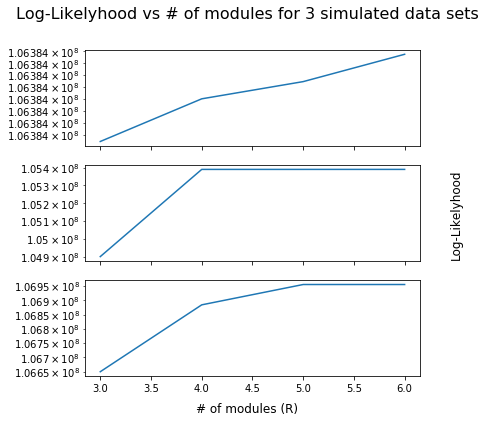

In [15]:
r_list = [3,4,5,6]
fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)
axs[0].semilogy(r_list, test_1[2])
axs[1].semilogy(r_list, test_2[2])
axs[2].semilogy(r_list, test_3[2])
fig.text(0.5, 0.04, "# of modules (R)", ha="center", fontsize=12)
fig.text(1, 0.5, "Log-Likelyhood", va="center", ha="right", rotation="vertical", fontsize=12)
fig.suptitle("Log-Likelyhood vs # of modules for 3 simulated data sets", fontsize=16)
plt.show()

(array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

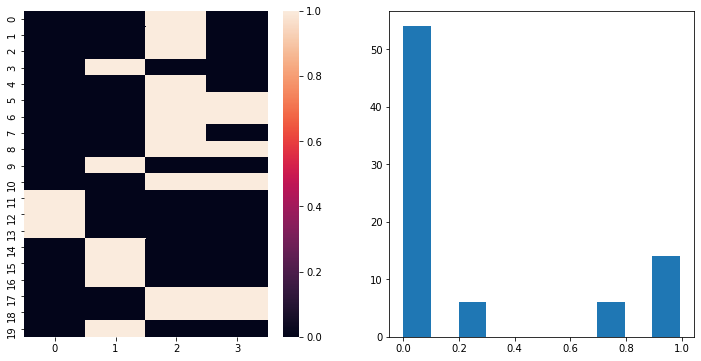

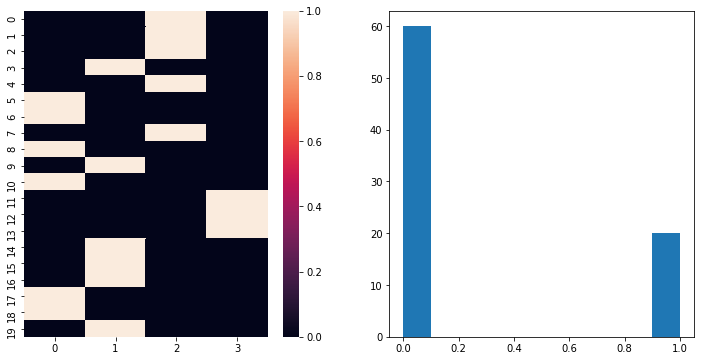

In [14]:
#TODO find a smarter way of creating the cutoff (variance or mean based maybe?)
W_hat = test_2[0][1]
row_norm_numer = W_hat.sum(axis=1)
W_hat = np.divide(W_hat, row_norm_numer[:,np.newaxis])

row_norm_numer = W2_true.sum(axis=1)
W2_true_norm = np.divide(W2_true, row_norm_numer[:,np.newaxis])

fig1, ax1 = plt.subplots(1, 2, figsize=(12,6))
sns.heatmap(W_hat>0.1, ax=ax1[0])
ax1[1].hist(W_hat.flatten())

fig2, ax2 = plt.subplots(1, 2, figsize=(12,6))
sns.heatmap(W2_true_norm>0, ax=ax2[0])
ax2[1].hist(W2_true_norm.flatten())

In [30]:
adler_data = pd.read_csv("w09-data.tbl", header=None, index_col=0, delim_whitespace=True)

array([[1375, 1491,  410, ...,  311, 1658, 1092],
       [  10,  220,   26, ...,  452,  147,   96],
       [1750, 2590,  726, ..., 1815, 2540, 2634],
       ...,
       [ 252,  265,   74, ...,   67,  327,  208],
       [ 764,  802,  210, ...,  182,  950,  544],
       [1540, 1640,  388, ...,  359, 2022, 1280]])

In [31]:
adler_data_results = find_best_fit_r(adler_data.values, (3,6), 5)

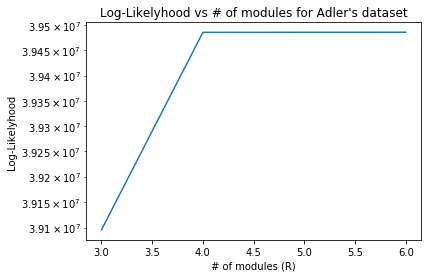

In [32]:
plt.semilogy(r_list, adler_data_results[2])
plt.xlabel("# of modules (R)")
plt.ylabel("Log-Likelyhood")
plt.title("Log-Likelyhood vs # of modules for Adler's dataset")
plt.show()

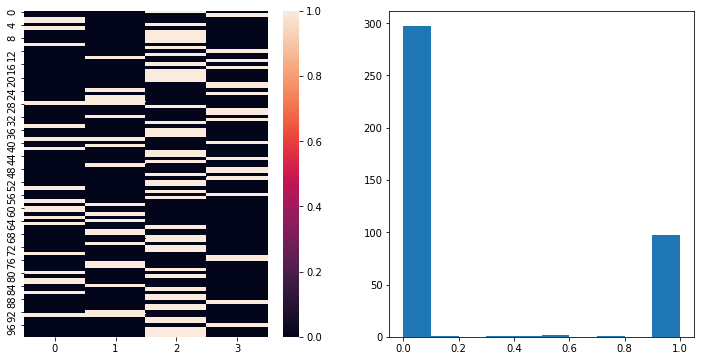

In [36]:
adler_W = adler_data_results[0][1]
row_norm_numer = adler_W.sum(axis=1)
adler_W = np.divide(adler_W, row_norm_numer[:,np.newaxis])

fig1, ax1 = plt.subplots(1, 2, figsize=(12,6))
sns.heatmap(adler_W>0.1, ax=ax1[0])
ax1[1].hist(adler_W.flatten())

plt.show()

In [9]:
W_hat.sum(axis=0)

array([3.02850105, 5.76618308, 6.28248266, 4.92283321])

In [10]:
print(test_1[2])
# So for these r=3 definetly looks better...
print(np.abs(1e6*np.matmul(test_1[0][0],test_1[1][0])-V1))
print(np.abs(1e6*np.matmul(test_1[0][3],test_1[1][3])-V1))
# But the sum for r=6 is lower..?
print(np.sum(np.abs(1e6*np.matmul(test_1[0][0],test_1[1][0])-V1)))
print(np.sum(np.abs(1e6*np.matmul(test_1[0][3],test_1[1][3])-V1)))

[106384257.32419571, 106384275.1149168, 106384282.2890033, 106384293.68746212]
[[7.95329480e+01 1.60507400e+02 3.06512128e+01 1.67127472e+02
  9.22076899e+01 8.11331374e+01 1.26580849e+02 4.33690438e+01
  5.45146272e+01 5.29929121e+01]
 [4.44006644e+01 2.95548247e+00 1.66559898e+01 7.47532110e+01
  1.49384894e+01 1.08959997e+01 2.85897885e+01 1.13691745e+02
  1.70937772e+01 6.70251673e+01]
 [2.23428439e+02 1.56304254e+01 1.23149936e+02 1.92081052e+01
  6.88444540e+01 2.80764974e+01 2.14310348e+01 2.73463949e+01
  2.67910611e+02 1.50600238e+01]
 [2.77436412e+02 5.11991659e+01 2.95367687e+02 1.97578226e+02
  1.90859677e+02 3.68941129e-01 2.07688947e+02 3.34513073e+02
  3.64747547e+02 5.10114827e+02]
 [7.98462607e+02 2.37224747e+00 1.28537959e+01 3.18377244e+02
  1.53894846e+02 1.22836700e+01 3.56566507e+01 3.40100196e+02
  2.17661303e+02 3.28180214e+02]
 [1.82679076e+02 5.73619747e+01 2.00965518e+00 1.98957025e+01
  2.47306014e+01 2.45411139e+01 9.53141867e+01 6.72147195e+01
  5.22765301

In [11]:
print(test_2[2])
# So for these r=3 definetly looks better...
print(np.abs(1e6*np.matmul(test_2[0][0],test_2[1][0])-V2))
print(np.abs(1e6*np.matmul(test_2[0][3],test_2[1][3])-V2))
# But the sum for r=6 is lower..?
print(np.sum(np.abs(1e6*np.matmul(test_2[0][0],test_2[1][0])-V2)))
print(np.sum(np.abs(1e6*np.matmul(test_2[0][3],test_2[1][3])-V2)))

[104900480.28877482, 105389830.51553376, 105389839.93267286, 105389849.93420699]
[[1.09439451e+04 1.05818271e+02 5.67373768e+03 1.04693172e+03
  2.52369171e+03 1.67970155e+04 8.77676840e+03 2.04878495e+04
  1.11476986e+03 7.64587110e+03]
 [1.84716556e+04 1.94963405e+02 9.82983543e+03 1.85297867e+03
  4.27831525e+03 2.85514357e+04 1.48102594e+04 3.48429436e+04
  1.90604570e+03 1.31409212e+04]
 [4.94178378e+04 4.40779203e+02 2.58874358e+04 5.07706825e+03
  1.14483936e+04 7.46908141e+04 3.87526903e+04 9.15428958e+04
  4.72685638e+03 3.40725494e+04]
 [2.39282544e+04 1.21462716e+04 1.30035867e+04 2.69894419e+03
  5.33558975e+03 3.88453291e+04 1.91302675e+04 4.37391881e+04
  6.91136055e+03 2.10147977e+04]
 [9.90586105e+03 9.91856437e+01 5.05259009e+03 9.83342103e+02
  2.18056954e+03 1.48882890e+04 7.95075810e+03 1.81187428e+04
  9.52702341e+02 6.65433433e+03]
 [3.86493463e+02 1.88177577e+03 9.87433537e+01 6.10907077e+01
  2.29411395e+01 6.39425636e+02 2.14458266e+02 4.42830691e+02
  8.778694

In [12]:
print(test_3[2])
# So for these r=3 definetly looks better...
print(np.abs(1e6*np.matmul(test_3[0][0],test_3[1][0])-V3))
print(np.abs(1e6*np.matmul(test_3[0][3],test_3[1][3])-V3))
# But the sum for r=6 is lower..?
print(np.sum(np.abs(1e6*np.matmul(test_3[0][0],test_3[1][0])-V3)))
print(np.sum(np.abs(1e6*np.matmul(test_3[0][3],test_3[1][3])-V3)))

[106649944.45363122, 106884001.73768404, 106955244.91484329, 106955253.35719538]
[[2.50967952e+03 6.59064083e+03 1.98663956e+04 3.46919094e+04
  3.81501647e+03 1.63051907e+03 2.91995150e+02 2.71906303e+04
  2.63472960e+04 9.87719318e+03]
 [1.38349638e+03 1.15382754e+02 9.75299927e+03 1.23538718e+04
  3.37205281e+03 5.04996333e+03 9.61588027e+02 9.60968364e+03
  1.62839457e+04 1.20934483e+04]
 [2.41149350e+03 8.72111191e+02 1.62955144e+03 1.67299010e+02
  1.65384167e+01 2.91948972e+03 1.18113885e+02 1.79233891e+03
  1.43378996e+03 1.48955142e+03]
 [2.81963598e+03 7.35783821e+03 2.23190038e+04 3.92304870e+04
  4.49060706e+03 1.96622517e+03 2.18873871e+02 3.08046387e+04
  2.96072196e+04 1.14702551e+04]
 [1.89508431e+02 5.43534619e+02 1.44614552e+03 2.51835801e+03
  2.12465159e+02 1.18237414e+02 1.70934355e+01 1.93258696e+03
  1.80932002e+03 7.42978826e+02]
 [1.98088544e+03 1.11105145e+03 1.13935577e+04 7.02234745e+03
  2.71599256e+03 3.20490090e+03 9.37444700e+02 1.39520082e+04
  1.540639

In [13]:
print(W_true.sum(axis=1))
print(test[0].sum(axis=1))
print(test[2])
# print(np.mean(test[1], axis=1))

NameError: name 'W_true' is not defined

In [ ]:
print(H_true)
print(test[1])

In [ ]:
a = 1e6*np.matmul(test[0], test[1])
b = V
print(a)
print(b)
print(a-b)

In [ ]:
# broadcast testing
a = np.array([[1,2,3],[4,5,6]])
a.sum(axis=1)